**Course website**: http://www.leouieda.com/geofisica1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [Jupyter notebook](http://jupyter.org/). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

# Prática 6 - Magnetometria - O IGRF e a anomalia magnética de campo total

## Objetivos

* Visualizar o campo magnético de referência [IGRF](http://en.wikipedia.org/wiki/International_Geomagnetic_Reference_Field).
* Verificar os efeitos da variação secular do campo geomagnético no último século.
* Visualizar o campo magnético induzido em um corpo para diferentes inclinações.
* Entender a relação entre campo magnético induzido, o campo magnético da Terra (IGRF) e a anomalia magnética de campo total.
* Entender o papel da inclinação magnética na forma da anomalia.

## Instruções

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

Para executar uma célula, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import ipywidgets as widgets
from IPython.display import display
import seaborn
import fatiando
from fatiando import gridder, mesher, utils
from fatiando.gravmag import prism, sphere
from fatiando.vis import mpl

In [2]:
print('Versão do Fatiando a Terra: {}'.format(fatiando.__version__))

Versão do Fatiando a Terra: 9c44e932513316fe9216305c1955bfead7437c59


## International Geomagnetic Reference Field (IGRF)

Abaixo, vamos fazer gráficos do IGRF calculado para a Terra toda. 
Os dados do IGRF foram gerados com o programa [Geomag 7](http://www.ngdc.noaa.gov/geomag/models.shtml).
Como o IGRF é um campo magnético, ele possui 3 componentes: inclinação, declinação e intensidade.

Rode as células abaixo para gerar mapas dessas 3 componentes para o ano 2000. 

Extra: para ver o campo de outras datas, mude o código `dado = igrf[igrf.year == 2000]` abaixo para ser o ano que deseja. Os dados disponíveis são de 1900 a 2000 a cada 10 anos.

In [3]:
igrf = pandas.read_csv('../data/igrf-1900-2010.csv', sep=';')

In [4]:
bm = Basemap(projection='moll', lon_0=0, resolution='c')
shape = (181, 90)
x, y = bm(igrf[igrf.year == 1900].longitude.as_matrix().reshape(shape), 
          igrf[igrf.year == 1900].latitude.as_matrix().reshape(shape))

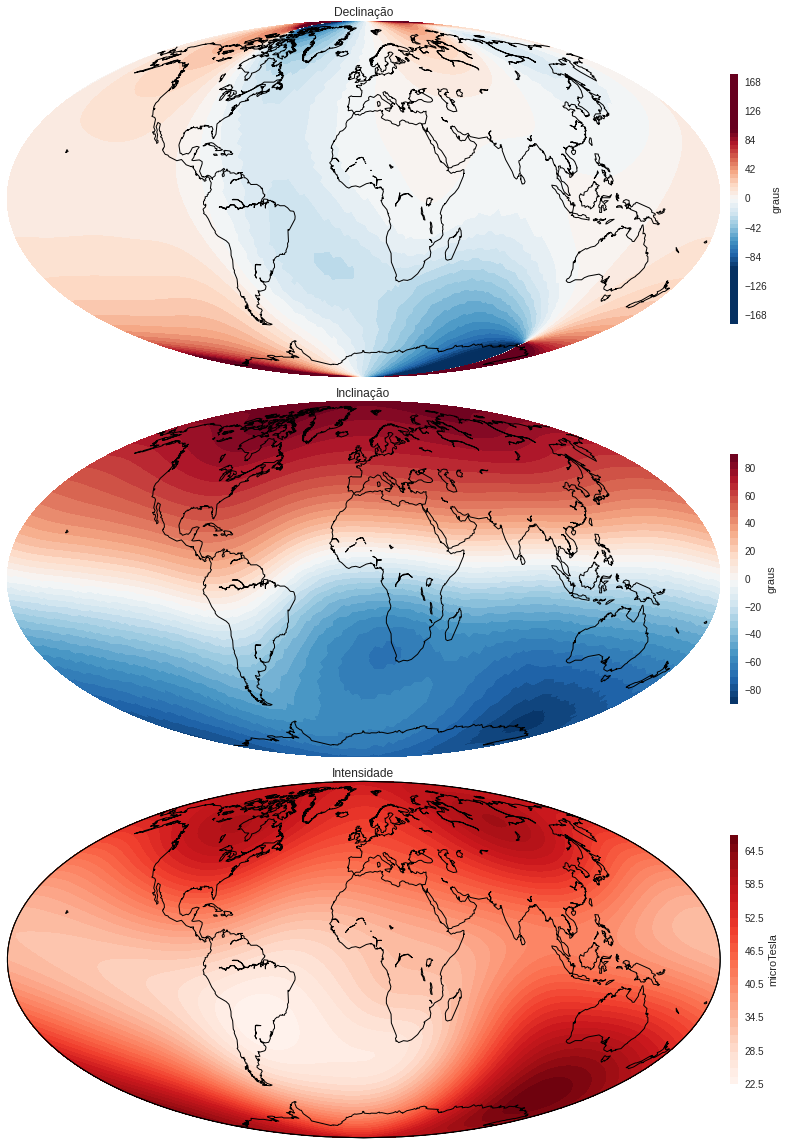

In [5]:
dado = igrf[igrf.year == 2000]

fig, axes = plt.subplots(3, 1, figsize=(14, 16))
ax1, ax2, ax3 = axes
ax1.set_title(u'Declinação')
ax2.set_title(u'Inclinação')
ax3.set_title('Intensidade')    
plot = bm.contourf(x, y, dado.dec.as_matrix().reshape(shape), 60, vmin=-100, vmax=100, ax=ax1, cmap='RdBu_r')
plt.colorbar(plot, orientation='vertical', aspect=30, shrink=0.7, pad=0.01, ax=ax1).set_label('graus')
bm.drawcoastlines(ax=ax1)
plot = bm.contourf(x, y, dado.inc.as_matrix().reshape(shape), 40, ax=ax2, cmap='RdBu_r')
plt.colorbar(plot, orientation='vertical', aspect=30, shrink=0.7, pad=0.01, ax=ax2).set_label('graus')
bm.drawcoastlines(ax=ax2)
plot = bm.contourf(x, y, dado.int.as_matrix().reshape(shape)*0.001, 40, ax=ax3, cmap='Reds')
plt.colorbar(plot, orientation='vertical', aspect=30, shrink=0.7, pad=0.01, ax=ax3).set_label('microTesla')
bm.drawcoastlines(ax=ax3)
plt.tight_layout()

## O campo magnético induzido em um cubo

Vamos ver como varia o campo magnético induzido em cubo para diferentes inclinações do campo magnético indutor.

Rode as células abaixo para criar um cubo e produzir uma figura interativa.

In [6]:
areacubo = [-400, 400, 400, 1200]
cubo = mesher.Prism(areacubo[0], areacubo[1], -50000, 50000, areacubo[2], areacubo[3])
area = (-1200, 1200, -400, 2000)
xp, yp, zp = gridder.regular(area, (13, 13), z=0)

In [7]:
def total_cubo(inc, suceptibilidade):
    cubo.addprop('magnetization', utils.ang2vec(suceptibilidade, inc, 0))
    def mask(area, v):
        x1, x2, y1, y2 = area
        v[(xp >= x1) & (xp <= x2) & (yp >= y1) & (yp <= y2)] = 0
        return v
    terra = utils.ang2vec(10000, inc, 0)
    bx = mask(areacubo, prism.bx(xp, zp, yp, [cubo]))
    bz = mask(areacubo, prism.bz(xp, zp, yp, [cubo]))
    tx =  bx + terra[0]
    tz =  bz + terra[2]
    fig, axes = plt.subplots(1, 2, sharey='all', figsize=(12, 6))
    ax1, ax2 = axes
    plt.sca(ax1)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    mpl.square(areacubo, fill='grey')
    plt.quiver(xp, yp, bx, bz, linewidth=0.5, 
               scale=50, pivot='middle', angles='xy', scale_units='xy')
    mx, my, mz = utils.ang2vec(suceptibilidade, inc, 0)
    plt.quiver([0], [800], [mx], [mz], linewidth=0.5, color='r',
               scale=1e-1, pivot='middle', angles='xy', scale_units='xy', zorder=1000)
    plt.hlines(0, area[0], area[1], linewidth=3)
    mpl.set_area(area)
    plt.gca().invert_yaxis()
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.title('Campo do corpo')    
    plt.sca(ax2)
    mpl.square(areacubo, fill='grey')
    plt.hlines(0, area[0], area[1], linewidth=3, zorder=1)
    plt.quiver(xp, yp, tx, tz, linewidth=0.5, color='b',
               scale=50, pivot='middle', angles='xy', scale_units='xy')
    plt.quiver([0], [800], [mx], [mz], linewidth=0.5, color='r',
               scale=1e-1, pivot='middle', angles='xy', scale_units='xy', zorder=1000)
    plt.quiver([-1000], [-0], [terra[0]], [terra[-1]], linewidth=0.5, color='y',
               scale=50, pivot='middle', angles='xy', scale_units='xy', zorder=1001)
    plt.xlabel('x (m)')
    plt.title('Campo total = corpo + Terra')    
    plt.tight_layout(pad=0)

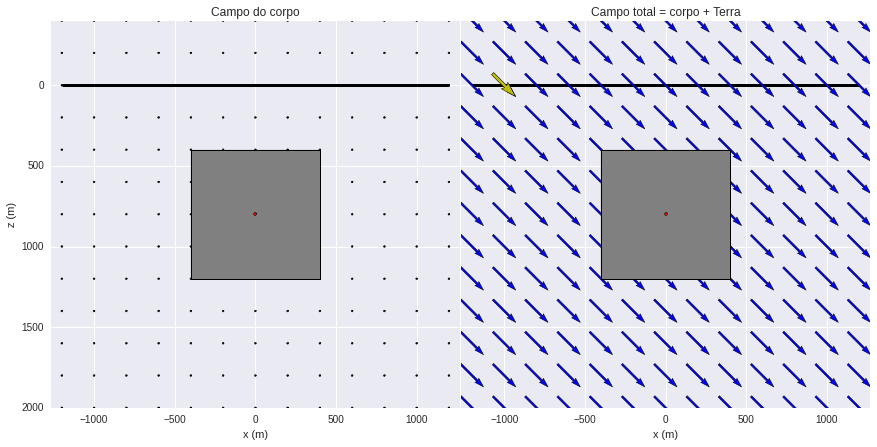

In [8]:
total_cubo(inc=45, suceptibilidade=0)

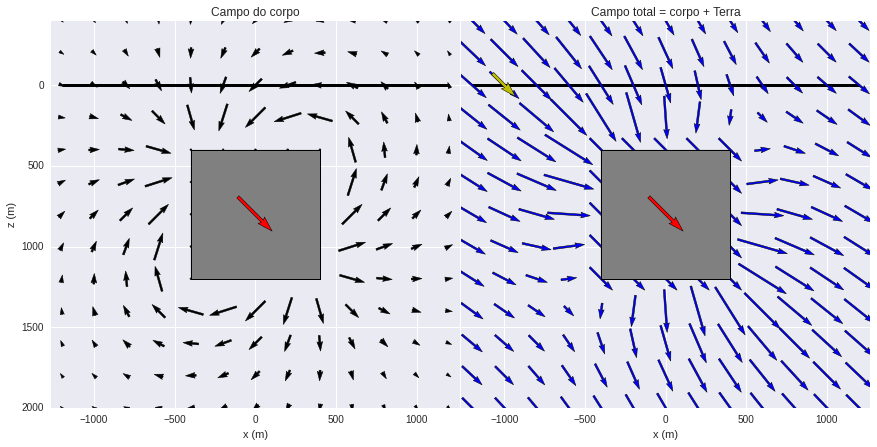

In [10]:
total_cubo(inc=45, suceptibilidade=30)

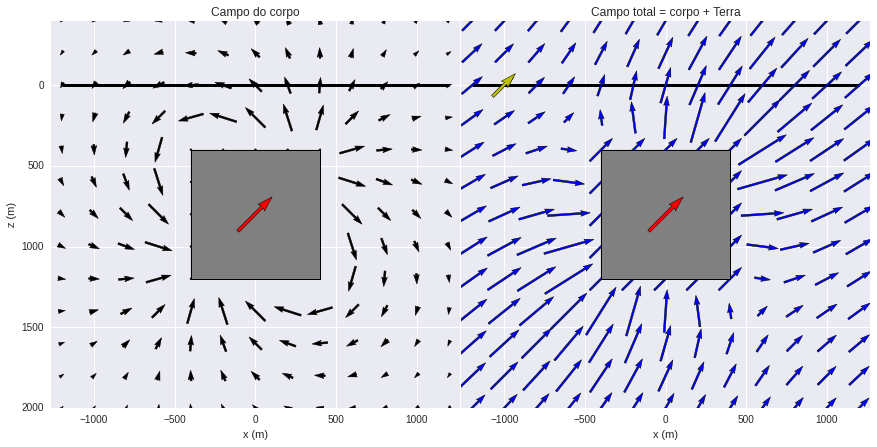

In [11]:
total_cubo(inc=-45, suceptibilidade=30)

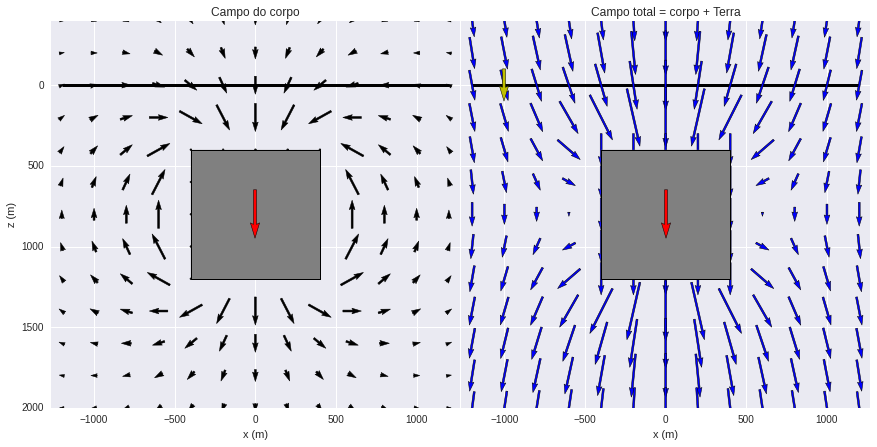

In [12]:
total_cubo(inc=90, suceptibilidade=30)

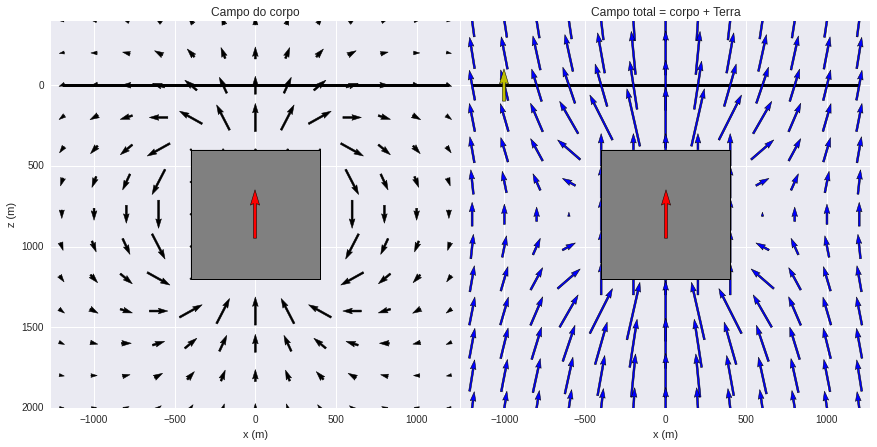

In [13]:
total_cubo(inc=-90, suceptibilidade=30)

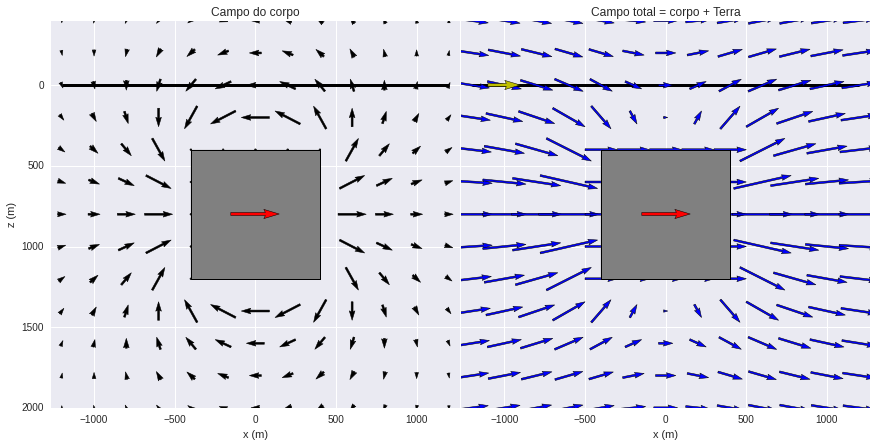

In [14]:
total_cubo(inc=0, suceptibilidade=30)

### Sobre a figura

* A figura da **esquerda** mostra o cubo (em cinza). A linha preta é a superfície (z = 0). 
* Na presença de um campo externo indutor, o corpo se magnetiza e gera um campo magnético. Esse campo será mostrado nessa figura em setas pretas.
* A figura da **direita** mostra o campo total presente, ou seja, o campo externo indutor (como o campo da Terra, por exemplo) mais o campo do cubo.
* A seta amarela na figura da direita mostra o campo da Terra.
* As setas vermelhas mostram a magnetização induzida no cubo pelo campo da Terra.